In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm, inv, solve
import statsmodels.api as sm

## Robust regression with Student's t likelihood

[Робастность](http://www.machinelearning.ru/wiki/index.php?title=%D0%A0%D0%BE%D0%B1%D0%B0%D1%81%D1%82%D0%BD%D0%BE%D0%B5_%D0%BE%D1%86%D0%B5%D0%BD%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5) - нечувствительность к малым отклонениям от предположений.

"Робастные пpоцедуpы оценки паpаметpов пpетендуют на то, чтобы давать хорошее соответствие общей стpуктуpе и пpи наличии pезко выделяю щихся наблюдений , как и в случае, когда pезко выделяющиеся наблюдения отсутствуют."

"Неpедко статистические данные, по котоpым стpоится pегpессионная модель, со деpжат pезко выделяющиеся на блюдения (outliers). Эти наблюдения существенно отделены от основной части и не подчиняются общей стpуктуpе. В каких-то сл учаях
такие выбpосы являются пpосто следствием ошибок, допущенных пpи сбоpе или обработке инфоpмации, но могут отpажать и pеальные эффекты."

$$\tau_i \sim \mathcal{G}am(a_0, b_0)$$
$$y_i | \tau_i  \sim \mathcal{N}(w^Tx_i, \tau_i^{-1}\sigma^2)$$

$$p(y) = \int p(y|\tau)p(\tau) d\tau = \int p(y, \tau) d\tau = \int \mathcal{N}(y|\mu, \tau^{-1}\sigma^2) \mathcal{G}am(\tau|a_0, b_0) d\tau$$

где

$\mathcal{N}(y|\mu, \tau^{-1}\sigma^2) = \frac{1}{\sqrt{2\pi}} \frac{\tau^{1/2}}{\sigma} e^{\frac{\tau}{2\sigma^2} (y - \mu)^2}$

$\mathcal{G}am(\tau|a, b) = \frac{b^{a}}{\Gamma(a)} \tau^{a-1} e^{-b\tau}$


$$p(y) = \int p(y|\tau)p(\tau) d\tau = \frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2})\sqrt{\pi s}\sigma} \left(1 + \frac{1}{s}\left(\frac{y - \mu}{\sigma} \right)^2 \right)^{-\frac{\nu+1}{2}}$$.

где $\nu = 2 a_0$, $s = \frac{b_0}{2}$.

В частном случае $\nu = s$ это [non-standardized Student's t-distribution](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D1%82%D1%8C%D1%8E%D0%B4%D0%B5%D0%BD%D1%82%D0%B0#%D0%9D%D0%B5%D1%81%D1%82%D0%B0%D0%BD%D0%B4%D0%B0%D1%80%D1%82%D0%B8%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D1%82%D1%8C%D1%8E%D0%B4%D0%B5%D0%BD%D1%82%D0%B0):

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cb9b96fa70e0609935a13cff73ba2141c7f22730">

<img src="https://cdn-images-1.medium.com/max/1200/1*aVZII0x6DoK8vE0_XgZaug.png">

Можно показать, что оценка параметров регрессионной модели методом максимального правдоподобия (ММП) с Гауссовским распределением шума сводится к задаче минимизации эмпирического риска с квадратичной функцией потерь: $\mathscr{l}(y, \hat{y}) = (y - \hat{y})^2$.

Если шум распределен согласно t-распределению Стьюдента, то оценка параметров ММП сводится к минимизации эмпирического риска с  функцией потерь вида: $\mathscr{l}(y, \hat{y}) = \log \left(1 + \frac{(y - \hat{y})^2}{\sigma^2}\right)$.

Во втором случае большие откроления $y$ от $\hat{y}$ "штрафуются" не так сильно.

На рисунке показаны примеры других функций потерь, используемых для [робастного](https://www.sebastiansylvan.com/post/robustestimation/) оценивания параметров.

<img src="https://www.sebastiansylvan.com/img/mest/loss.svg">

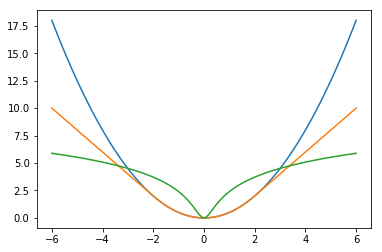

In [5]:
from scipy.special import huber

e = np.linspace(-6, 6, 100)

plt.plot(e, 0.5*e**2)
plt.plot(e, huber(2, e))
plt.plot(e, np.log(1 + e**2/0.1))
plt.show()

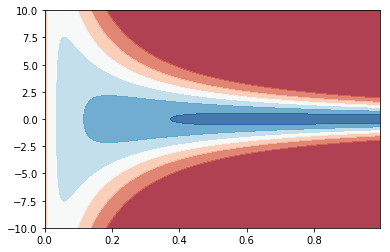

In [112]:
from scipy.stats import norm, gamma

def joint_pdf(x):
    sigma = 1
    a0 = 0.2
    b0 = 0.2
    
    tau = x[:,0]
    y = x[:,1]
    
    pdf = norm.pdf(y, loc=0*y, scale=sigma**2/tau) * gamma.pdf(tau, a0, scale=1/b0)
    
    return pdf
    

h = .005  # step size in the mesh
tau_min, tau_max = 1e-5, 1
y_min, y_max = -10, 10
xx, yy = np.meshgrid(np.arange(tau_min, tau_max, h), np.arange(y_min, y_max, h))

x = np.c_[xx.ravel(), yy.ravel()]

Z = joint_pdf(x).reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
plt.show()

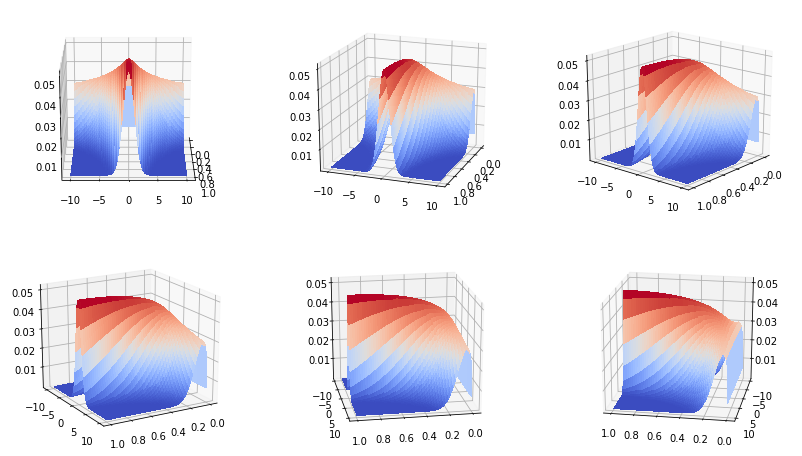

In [119]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import product


fig = plt.figure()
fig.set_size_inches(14, 8)
for row, col in product(range(2), range(3)):
    idx = row * 3 + col
    ax = plt.subplot(2, 3, idx + 1, projection='3d')   
    ax.plot_surface(xx, yy, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(elev=20., azim=20*idx)
plt.show()

$\mathbb{E}\{\tau\} = \frac{a}{b}$ если $p(\tau) = \mathcal{G}am(\tau | a, b)$

https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf

In [2]:
def reg_posteriors(Y, X, w, a0, b0, sigma):
    a = a0 + 0.5
    b = b0 + 0.5/sigma*(Y - X.dot(w))**2
    return a/b

In [3]:
np.random.seed(seed=2)

n = 50

x = np.sort(np.random.rand(n,1)*20, axis=0)
Y = 0.5*x + np.random.randn(n,1)*0.4

# outliers
Y[13] = 14
Y[14] = 13
Y[15] = 14.5
Y[16] = 12

X = np.hstack((x, np.ones((x.shape[0], 1)))) ###

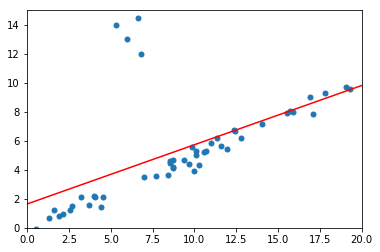

In [4]:
from scipy.linalg import pinv

#pp = np.ones((X.shape[0], 1))
#w = sm.WLS(Y, X, pp).fit().params

w = pinv(X).dot(Y)

w = w.reshape(2, 1)

# show
plt.plot(X[:, 0], Y, '.', markersize=10)
t = np.arange(0, 20, 0.01)
plt.plot(t, w[0]*t + w[1], 'r')
plt.axis((0,20,0,15))
plt.show()

In [5]:
w = np.random.randn(2, 1)
sigma = 1
a0 = 0.2
b0 = 0.2

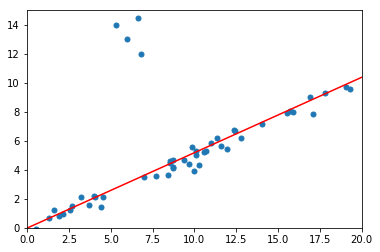

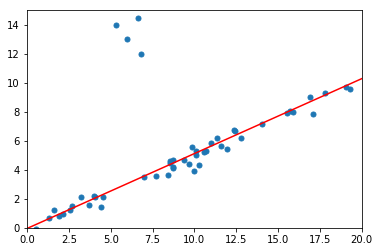

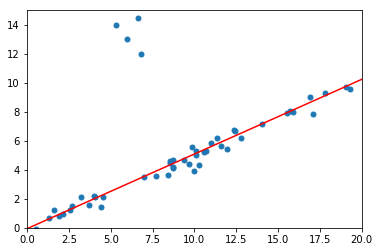

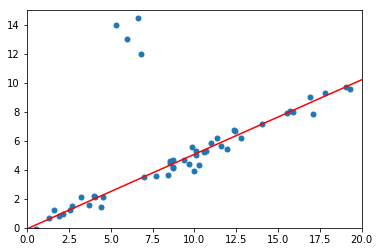

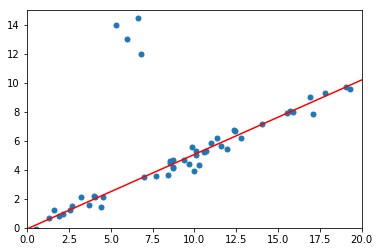

In [6]:
# EM
n_iter = 5
for i in range(n_iter):

    # E
    pp = reg_posteriors(Y, X, w, a0, b0, sigma)

    # M
    w = sm.WLS(Y, X, pp).fit().params
    w = w.reshape(2,1)
    sigma = np.mean(pp*(Y - np.dot(X,w))**2)

    # show
    plt.clf()
    plt.plot(X[:, 0], Y, '.', markersize=10)
    t = np.arange(0, 20, 0.01)
    plt.plot(t, w[0]*t + w[1], 'r')
    plt.axis((0,20,0,15))
    plt.draw()
    plt.pause(1)

plt.show()

## Gaussian mixture model

$$ y_i \sim \mathcal{C}at(\pi)$$
$$x_i | y_i \sim \mathcal{N}(\mu_{y_i}, \Sigma_{y_i})$$

$$x_i \sim \sum_{k=1}^K \pi_k \mathcal{N}(\mu_k, \Sigma_k)$$

<img src="http://www.lix.polytechnique.fr/~nielsen/MEF/matlab/mef.png">


http://www.machinelearning.ru/wiki/images/1/17/MMP_Practicum_317_2015_EM_algorithm.pdf

In [7]:
from scipy.stats import multivariate_normal
from scipy.misc import logsumexp
from matplotlib.patches import Ellipse

In [8]:
def plotcov(cov, pos, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    if ax is None:
        ax = plt.gca()
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_artist(ellip)
    return ellip

In [9]:
def gmm_posteriors(X, K, p, mu, Sigma):
    post = np.zeros((X.shape[0], K))
    for k in range(K):
        post[:,k] = np.log(p[k]+1e-16) + multivariate_normal.logpdf(X, mu[k,:], Sigma[:,:,k]) ##
    return np.exp(post - logsumexp(post, axis=1)[:,np.newaxis]) ##

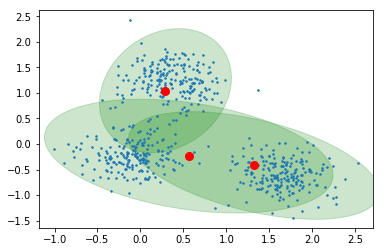

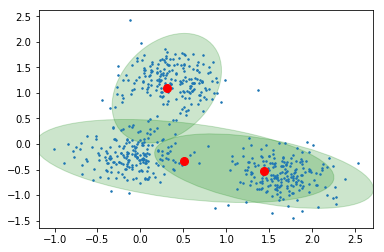

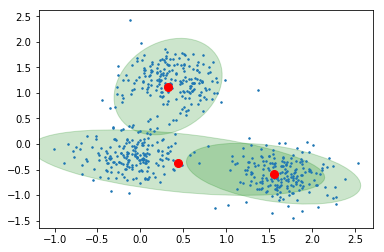

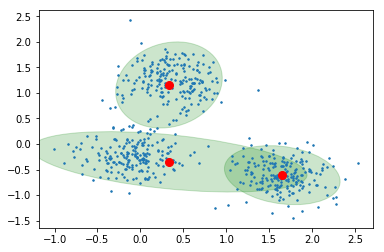

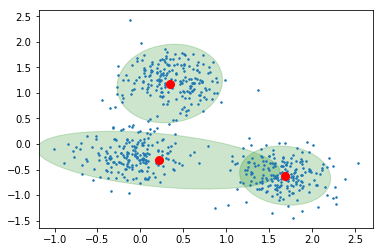

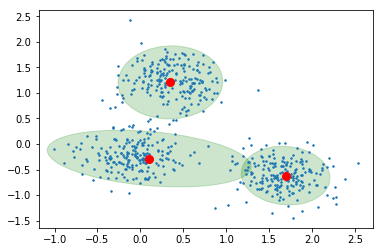

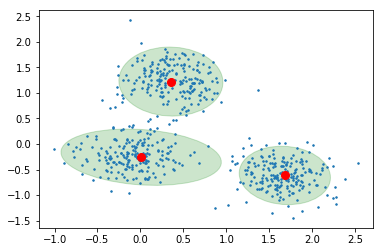

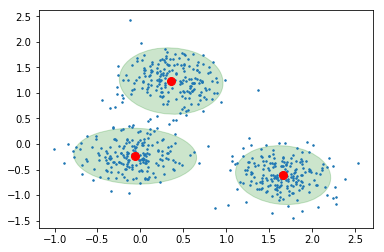

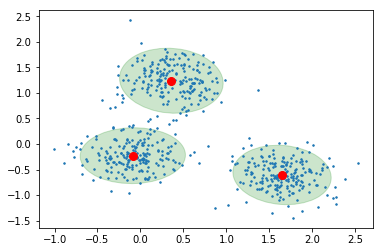

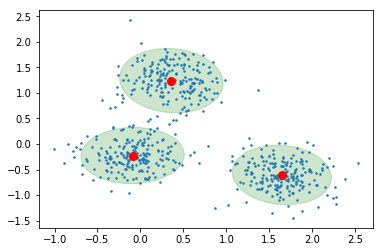

In [10]:
   
np.random.seed(seed=1)

K = 3

n = 200
dim = 2
X = np.zeros((0, dim))
for k in range(K):
    mu = np.random.randn(1,dim)
    X = np.vstack((X, mu + np.random.randn(n,dim)*0.3))


p = np.ones((K, 1))/K;
mu = np.random.randn(K, dim)
Sigma = np.repeat(np.eye(dim, dim)[...,np.newaxis], K, 2)

# EM
n_iter = 10
for i in range(n_iter):

    # E
    pp = gmm_posteriors(X, K, p, mu, Sigma)

    # M
    p = np.mean(pp, axis=0)
    mu = np.dot(pp.T, X)/np.sum(pp, axis=0).T[:,np.newaxis]
    for k in range(K):
        Xk = (X - mu[k,:])*np.sqrt(pp[:,k])[:,np.newaxis]
        Sigma[:,:,k] = np.dot(Xk.T, Xk)/np.sum(pp[:,k])## 

    # show
    plt.clf()
    plt.plot(X[:, 0], X[:, 1], '.', markersize=3)
    plt.plot(mu[:, 0], mu[:, 1], 'ro', markersize=8)
    for k in range(K):
        plotcov(Sigma[:,:,k], mu[k,:], alpha=0.2, color='green')
    plt.draw()
    plt.pause(1)

plt.show()


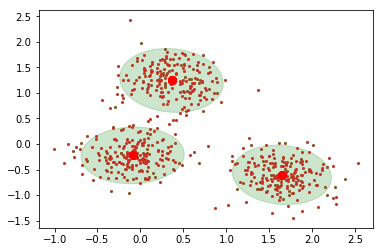

In [58]:
from sklearn import mixture

# GMM
gmm = mixture.GaussianMixture(n_components=K, covariance_type='full')
gmm.fit(X)


mu, Sigma = gmm.means_, gmm.covariances_
Sigma = np.moveaxis(Sigma, 0, 2)


plt.plot(X[:, 0], X[:, 1], '.', markersize=3)
plt.plot(mu[:, 0], mu[:, 1], 'ro', markersize=8)
for k in range(K):
    plotcov(Sigma[:,:,k], mu[k,:], alpha=0.2, color='green')
plt.draw()
plt.pause(1)

plt.show()

In [6]:
from scipy.linalg import norm, inv, solve
#from scipy.stats import multivariate_normal
from scipy.optimize import minimize, check_grad

import statsmodels.api as sm

## Mixture of experts

In [94]:
import autograd.numpy as anp
from autograd import value_and_grad, grad

import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as normal
from autograd.scipy.misc import logsumexp

In [192]:
class MoE:
    def __init__(self, dim, n_exp):
        self.V = np.random.randn(n_exp, dim)
        self.w = np.random.randn(n_exp, dim)
        self.K = n_exp
        self.sigma = 0.5 # known
        
    def _log_exp_lik(self, v, X, Y, lmbda):
        V = v.reshape(Y.shape[1], X.shape[1])
        S = anp.dot(X, V.T)
        logp = S - logsumexp(S, axis=1, keepdims=True)
        return -anp.mean(Y * logp) + 0.5*lmbda*anp.sum(V**2)
        
    def posterior_probs(self, X, Y):
        S = np.dot(X, self.V.T)
        post = S - logsumexp(S, axis=1, keepdims=True)
        for k in range(self.K):
            post[:,k] += normal.logpdf(Y.flatten(), np.dot(X, self.w[k,:].T), self.sigma)
        return np.exp(post - logsumexp(post, axis=1, keepdims=True))
        
    def fit(self, X, Y, lmbda):
        
        max_iter = 200
        for i in range(max_iter):

            # E-step
            post_probs = self.posterior_probs(X, Y)

            # M-step
            for k in range(self.K):
                p = post_probs[:,k][:,np.newaxis]
                self.w[k,:] = sm.WLS(Y, X, p).fit().params
                #self.w[k,:] = solve(np.dot(X.T, p*X) + 1e-10*np.eye(dim+1), np.dot((p*Y).T, X).T).flatten()

            f = lambda M: self._log_exp_lik(M, X, post_probs, lmbda)
            #fgrad = lambda M: logpz_grad(M, X, post_probs)
            fgrad = grad(f)
            
            x = minimize(f, self.V.flatten(), method='L-BFGS-B', jac=fgrad, options={'gtol': 1e-5, 'disp': False}).x
            self.V = x.reshape(self.K, X.shape[1])


In [193]:
n = 100

np.random.seed(10)

x = np.sort(np.random.rand(3*n,1)*20, axis=0)
y1 = 1*x[0:n]+1
y2 = 9-0.3*x[n:2*n]
y3 = 0.7*x[2*n:]-4
Y = np.vstack((y1, y2, y3)) + np.random.randn(3*n,1)*0.5

X = np.hstack((x, np.ones((x.shape[0], 1))))

In [194]:
dim = 1
K = 3

regularization_const = 0.001

moe = MoE(dim+1, K)
moe.fit(X, Y, regularization_const)

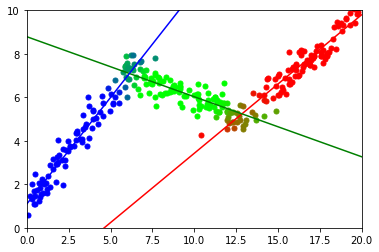

In [195]:
pp = moe.posterior_probs(X, Y)

for n in range(X.shape[0]):
    plt.plot(X[n, 0], Y[n], '.', color=[pp[n,0], pp[n,1], pp[n,2]], markersize=10)
t = np.arange(0, 20, 0.01)
plt.plot(t, moe.w[0,0]*t + moe.w[0,1], 'r')
plt.plot(t, moe.w[1,0]*t + moe.w[1,1], 'g')
plt.plot(t, moe.w[2,0]*t + moe.w[2,1], 'b')
plt.axis((0,20,0,10))

plt.show()